Set up library imports

In [1]:
import requests, re, json, praw, pprint, time
import pandas as pd
import numpy as np
from psaw import PushshiftAPI    # PSAW recommended by following PRAW errors
import datetime as dt            # PSAW docs
from IPython.display import display
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
import plotly


## Objective: What are some important features of hot Reddit posts?

In [20]:
!source activate dsi

In [22]:
!conda install -c plotly plotly -y

Solving environment: done

## Package Plan ##

  environment location: /Users/saqibnizami/anaconda3/envs/dsi

  added / updated specs: 
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.4.16          |           py36_0         142 KB
    plotly-2.7.0               |           py36_1        20.0 MB
    openssl-1.0.2o             |       h26aff7b_0         3.4 MB
    ------------------------------------------------------------
                                           Total:        23.5 MB

The following packages will be UPDATED:

    certifi: 2018.4.16-py36_0 conda-forge --> 2018.4.16-py36_0 
    openssl: 1.0.2o-0         conda-forge --> 1.0.2o-h26aff7b_0
    plotly:  2.5.1-py36_0                 --> 2.7.0-py36_1     


certifi-2018.4.16    |  142 KB | ####################################### | 100% 
plotly-2.7.0         | 20.0 MB | ##############################

In [5]:
# Initializing reddit API

reddit = praw.Reddit(client_id='CmKUgfSklwH6Gw',
                     client_secret='WprZwImA7V8TcggsN0GfpZOfl2g',
                     user_agent='ClassProjectBot-PRAW/PSAW',
                     password='dsBaLpQSua2ctCXU2XyupJ',
                     username='refused_dev')

# Set PushShiftAPI
api = PushshiftAPI()

# Set a variable equal to the target subreddit
r_all = reddit.subreddit('all')

In [ ]:
# Grab submissions from the subreddit
subs = []
for sub in r_all.hot(limit=None):
    sub_dict = {}
    sub_dict['submissions'] = sub
    subs.append(sub_dict)
subscrape = pd.DataFrame(subs)
subscrape.shape, subscrape.head()

# Save submission pull to csv
subscrape.to_csv("subs.csv")

In [ ]:
# Grab features from the submission IDs
sublist = []
for c in subscrape['submissions']:
    subdict = {}
    subdict['title'] = c.title
    subdict['comments'] = c.num_comments
    subdict['crossposts'] = c.num_crossposts
    subdict['score'] = c.score
    subdict['subreddit'] = c.subreddit
    subdict['domain'] = c.domain
    subdict['gilded'] = c.gilded
    subdict['upvote_ratio'] = c.upvote_ratio
    subdict['created'] = c.created
    fri_sublist.append(subdict)

df = pd.DataFrame(sublist)

def get_date(created):
    return dt.datetime.fromtimestamp(created)

stamp = data['created'].apply(get_date)
data = data.assign(timestamp = stamp)
data.drop(columns='created', inplace=True)
data.to_csv('9068df_with_time.csv')

Load up previous scrapes

In [2]:
df = pd.read_csv('df_w_feats.csv')
display(df.shape, df.head().sort_values('score', ascending=False))

(22767, 10)

,Unnamed: 0,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio
2,2,3232,1.527744e+09,4,youtube.com,5,83372,videos,Gamer bet if the new Bethesda reveal was not F...,0.78
3,3,2439,1.527740e+09,6,smh.com.au,0,61556,worldnews,"Police faked 258,000 breath tests in shocking ...",0.89
0,0,268,1.527746e+09,1,i.redd.it,0,54696,BikiniBottomTwitter,About to make a splash? More like just about t...,0.82
1,1,3771,1.527740e+09,2,thehill.com,0,39344,politics,FBI is reconstructing shredded documents obtai...,0.89
4,4,275,1.527748e+09,0,i.redd.it,0,31701,PrequelMemes,"Always 2 there are, no more, no less",0.85


In [3]:
# df.drop(columns='Unnamed: 0', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22767 entries, 0 to 22766
Data columns (total 10 columns):
Unnamed: 0      22767 non-null int64
comments        22767 non-null int64
created         22767 non-null float64
crossposts      22767 non-null int64
domain          22767 non-null object
gilded          22767 non-null int64
score           22767 non-null int64
subreddit       22767 non-null object
title           22767 non-null object
upvote_ratio    22767 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.7+ MB


In [4]:
# convert unix timecode to human readable

def get_date(created):
    return dt.datetime.fromtimestamp(created)
stamp = df['created'].apply(get_date)
df = df.assign(timestamp = stamp)

In [5]:
display(df.shape,df.head())

(22767, 11)

,Unnamed: 0,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp
0,0,268,1.527746e+09,1,i.redd.it,0,54696,BikiniBottomTwitter,About to make a splash? More like just about t...,0.82,2018-05-31 01:59:13
1,1,3771,1.527740e+09,2,thehill.com,0,39344,politics,FBI is reconstructing shredded documents obtai...,0.89,2018-05-31 00:20:29
2,2,3232,1.527744e+09,4,youtube.com,5,83372,videos,Gamer bet if the new Bethesda reveal was not F...,0.78,2018-05-31 01:14:48
3,3,2439,1.527740e+09,6,smh.com.au,0,61556,worldnews,"Police faked 258,000 breath tests in shocking ...",0.89,2018-05-31 00:14:09
4,4,275,1.527748e+09,0,i.redd.it,0,31701,PrequelMemes,"Always 2 there are, no more, no less",0.85,2018-05-31 02:31:16


In [35]:
# df['datetime'] = df.timestamp.values.astype('datetime64[D]')

In [6]:
# calculate percentiles

p25, p50, p75 = np.percentile(df.comments, 25), np.percentile(df.comments, 50), np.percentile(df.comments, 75)
print(p25, p50, p75)

df['p25'] = df['comments'] <= p25
df['p50'] = df['comments'] <= p50
df['p75'] = df['comments'] <= p75

# posts with over the median amount of comments are a success

# dft['success'] = dft['p50'].map({False : 1, True : 0})
df['over25p'] = df['p25'].map({False : 1, True : 0})
df['over50p'] = df['p50'].map({False : 1, True : 0}) # median
df['over75p'] = df['p75'].map({False : 1, True : 0})

df.drop(columns=['p25','p50','p75','Unnamed: 0'], inplace=True)

11.0 31.0 86.0


In [7]:
df.columns

Index(['comments', 'created', 'crossposts', 'domain', 'gilded', 'score',
       'subreddit', 'title', 'upvote_ratio', 'timestamp', 'over25p', 'over50p',
       'over75p'],
      dtype='object')

In [8]:
y = df['over50p']
y.shape

(22767,)

## Subreddit Analysis

In [9]:
trainx, testx, trainy, testy = train_test_split(df, y, test_size=.20,
                                                    random_state=19)

In [10]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((18213, 13), (18213,), (4554, 13), (4554,))

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



[(0, 1000)]

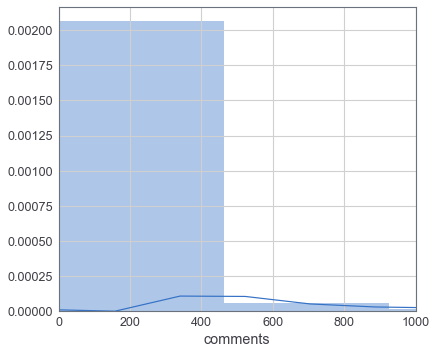

In [11]:
jtplot.style()
# setting axis range in seaborn:
sns.distplot(trainx['comments'], norm_hist=True).set(xlim=(0,1000))


In [14]:
# CountVectorize subreddits to find out which ones are the most common in the dataset.

cvec = CountVectorizer() # no stop_words since its just subreddit names
trainx_counts = cvec.fit_transform(trainx['subreddit'])
xtrainbag = pd.DataFrame(trainx_counts.todense(), 
                         columns=cvec.get_feature_names())
xtrainbag.sum(axis=0).sort_values(ascending=False).head(50)

# make a word cloud here!

the_donald              639
politics                358
ice_poseidon            336
dankmemes               222
me_irl                  197
aww                     176
funny                   157
pewdiepiesubmissions    146
kanye                   127
soccer                  125
nba                     122
memes                   118
animemes                115
fortnitebr              109
prequelmemes            106
ddlc                    105
gaming                   98
tumblr                   95
blackpeopletwitter       93
deepfriedmemes           88
pics                     69
cringeanarchy            65
greentext                63
todayilearned            61
dota2                    59
greatawakening           58
celebs                   58
globaloffensive          57
hmmm                     55
worldnews                54
showerthoughts           54
mildlyinteresting        53
rupaulsdragrace          52
grandorder               52
gifs                     49
2meirl4meirl        

In [15]:
# pipeline to evaluate subreddits vs success

pipe = make_pipeline(CountVectorizer(),
                    RandomForestClassifier(random_state=42))
pipe.fit(trainx['subreddit'], trainy)
pipe.score(testx['subreddit'], testy)

0.7217830478700044

In [16]:
pred = pipe.predict(testx['subreddit'])
print(classification_report(pred, testy))

             precision    recall  f1-score   support

          0       0.76      0.71      0.73      2483
          1       0.68      0.74      0.71      2071

avg / total       0.73      0.72      0.72      4554



In [ ]:
# # See which features our inital RandomForest model has deemed to be important:

rfc_feats = pipe.steps[1][1].feature_importances_
rfc_featname = pipe.steps[0][1].get_feature_names()
rfc_featrank = pd.DataFrame(data=rfc_feats, index=rfc_featname)
rfc_featrank.rename(columns={0:"importance"}, inplace=True)

In [31]:
# keep the top 500 subreddits out of 3288
rfc_featrank.sort_values("importance", ascending=True).head(500)

,importance
gloomhaven,0.0
sodapoppin,0.0
pointlesslygendered,0.0
colorado,0.0
solarsysgals,0.0
sophiedee,0.0
dndmemes,0.0
juul,0.0
justoneboob,0.0
soundslikemusic,0.0


In [37]:
rfc_featrank[rfc_featrank["importance"] > 0].sort_values("importance", ascending=True).head(100)
# Taking all the non-zero importance subs might be better.

,importance
kitty,2.881762e-11
porn_gifs,2.966904e-11
emogirls,3.385696e-11
tanime,3.395971e-11
notsafefornature,3.406293e-11
kittengifs,3.469865e-11
anriokita,3.556446e-11
lodeddiper,3.601028e-11
kindafunny,3.606995e-11
machinelearning,3.630606e-11


In [29]:
# make a list to filter down dataset later
top_subs = list(rfc_featrank.sort_values("importance", ascending=False).head(2000).index)
#might need more than 

In [19]:
trainx.sort_values('comments', ascending=False)

# a comment/score ratio might be a good feature to determine active participation
comrat = []
for x in trainx.index:
    comrat.append((trainx['comments'][x])/(trainx['score'][x]))
trainx['comment_ratio']=comrat

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [20]:
display(trainx.sort_values("comment_ratio", ascending=False))
# self posts seem to have the highest comment_ratio, another feature could be 'is_self'

,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,over25p,over50p,over75p,comment_ratio
418,21146,1.527748e+09,0,self.hockey,0,1526,hockey,Game Day Thread: SCF Game 2 - Washington Capit...,0.96,2018-05-31 02:33:02,1,1,1,13.857143
20055,1051,1.527905e+09,0,self.soccer,0,93,soccer,Daily Discussion [2018-06-01],0.88,2018-06-01 22:09:06,1,1,1,11.301075
11492,647,1.527799e+09,0,salon.com,0,63,politics,Democrats gear up for 2020 — and Bernie Sander...,0.68,2018-05-31 16:44:19,1,1,1,10.269841
17652,2890,1.527885e+09,0,self.NintendoSwitch,0,346,NintendoSwitch,"We're giving away a $10 eShop card, all you ne...",0.84,2018-06-01 16:32:28,1,1,1,8.352601
19488,1234,1.527908e+09,0,self.soccer,0,166,soccer,Match Thread: France vs. Italy [International ...,0.97,2018-06-01 22:53:52,1,1,1,7.433735
6998,618,1.527801e+09,0,self.CFB,0,95,CFB,"What is ""the game"" that opposing fans hold aga...",0.89,2018-05-31 17:04:08,1,1,1,6.505263
19909,3891,1.527853e+09,0,self.Kanye,0,644,Kanye,ALBUM LISTENING MEGA-THREAD II,0.98,2018-06-01 07:44:47,1,1,1,6.041925
6210,957,1.527793e+09,0,self.Naruto,0,194,Naruto,BORUTO: NARUTO NEXT GENERATIONS Episode 60 - L...,0.99,2018-05-31 14:56:19,1,1,1,4.932990
18390,448,1.527896e+09,0,self.MMA,0,91,MMA,Rematches: Who do you think would absolutely w...,0.89,2018-06-01 19:33:10,1,1,1,4.923077
18447,1740,1.527885e+09,0,self.AskReddit,0,372,AskReddit,What food does everyone seem to love that you ...,0.88,2018-06-01 16:31:11,1,1,1,4.677419


In [92]:
trainx.query("over50p == 0").sort_values("comment_ratio", ascending=False)

,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,over25p,over50p,over75p,comment_ratio
5995,31,1.527797e+09,0,i.redd.it,0,45,Harley,My week old Harley got rear ended at a red lig...,0.94,2018-05-31 15:57:19,1,0,0,0.688889
15883,27,1.527895e+09,0,twitter.com,0,61,barstoolsports,ESPN’s next big star: blackjack fletcher,0.90,2018-06-01 19:13:29,1,0,0,0.442623
6731,30,1.527805e+09,0,self.NewYorkMets,0,69,NewYorkMets,"Minimum 140 PAs, Brandon Nimmo's 171 wRC+ is f...",0.98,2018-05-31 18:22:32,1,0,0,0.434783
19018,28,1.527900e+09,0,odditycentral.com,0,67,news,Chinese School Uses Facial Recognition to Moni...,0.83,2018-06-01 20:34:35,1,0,0,0.417910
10349,29,1.527798e+09,0,self.greatawakening,0,70,greatawakening,Looks like there is an attempt to push divisio...,0.86,2018-05-31 16:20:56,1,0,0,0.414286
15108,14,1.527909e+09,0,self.FUTMobile,0,34,FUTMobile,[other] Anyone else login failed?,0.92,2018-06-01 23:02:47,1,0,0,0.411765
11325,31,1.527798e+09,1,bloomberg.com,0,76,politics,"Trump’s Net Worth Slides to $2.8 Billion, Lowe...",0.82,2018-05-31 16:21:30,1,0,0,0.407895
16011,27,1.527895e+09,0,self.fantasybaseball,0,67,fantasybaseball,Wil Myers (oblique) could be out until July,1.00,2018-06-01 19:14:17,1,0,0,0.402985
5893,28,1.527806e+09,0,self.RepLadies,0,70,RepLadies,Min Group Buy - Louis Vuitton Pochette Metis f...,1.00,2018-05-31 18:25:41,1,0,0,0.400000
8600,22,1.527808e+09,0,i.redd.it,0,55,trashy,Another classy statement,0.95,2018-05-31 19:09:50,1,0,0,0.400000


In [97]:
trainx.query("over50p == 1").sort_values("comment_ratio", ascending=False)

,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,over25p,over50p,over75p,comment_ratio
418,21146,1.527748e+09,0,self.hockey,0,1526,hockey,Game Day Thread: SCF Game 2 - Washington Capit...,0.96,2018-05-31 02:33:02,1,1,1,13.857143
20055,1051,1.527905e+09,0,self.soccer,0,93,soccer,Daily Discussion [2018-06-01],0.88,2018-06-01 22:09:06,1,1,1,11.301075
11492,647,1.527799e+09,0,salon.com,0,63,politics,Democrats gear up for 2020 — and Bernie Sander...,0.68,2018-05-31 16:44:19,1,1,1,10.269841
17652,2890,1.527885e+09,0,self.NintendoSwitch,0,346,NintendoSwitch,"We're giving away a $10 eShop card, all you ne...",0.84,2018-06-01 16:32:28,1,1,1,8.352601
19488,1234,1.527908e+09,0,self.soccer,0,166,soccer,Match Thread: France vs. Italy [International ...,0.97,2018-06-01 22:53:52,1,1,1,7.433735
6998,618,1.527801e+09,0,self.CFB,0,95,CFB,"What is ""the game"" that opposing fans hold aga...",0.89,2018-05-31 17:04:08,1,1,1,6.505263
19909,3891,1.527853e+09,0,self.Kanye,0,644,Kanye,ALBUM LISTENING MEGA-THREAD II,0.98,2018-06-01 07:44:47,1,1,1,6.041925
6210,957,1.527793e+09,0,self.Naruto,0,194,Naruto,BORUTO: NARUTO NEXT GENERATIONS Episode 60 - L...,0.99,2018-05-31 14:56:19,1,1,1,4.932990
18390,448,1.527896e+09,0,self.MMA,0,91,MMA,Rematches: Who do you think would absolutely w...,0.89,2018-06-01 19:33:10,1,1,1,4.923077
18447,1740,1.527885e+09,0,self.AskReddit,0,372,AskReddit,What food does everyone seem to love that you ...,0.88,2018-06-01 16:31:11,1,1,1,4.677419


In [96]:
trainx.query("comment_ratio >= 1 & over50p == 0").sort_values("comment_ratio", ascending=False)

# comment ratio might be another possible target, along with over25p and over75p, these and created should be dropped from the dataset going forward.


,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,over25p,over50p,over75p,comment_ratio


In [100]:
comtesty = pd.Series()
comrat = []
for x in testx.index:
    comrat.append((testx['comments'][x])/(testx['score'][x]))
comtesty['comment_ratio']=comrat
comtesty.values

comtrainy = trainx["comment_ratio"]


pipe = make_pipeline(CountVectorizer(),
                    LinearRegression())
pipe.fit(trainx['subreddit'], comtrainy.values)
pipe.score(testx['subreddit'], comtesty.values)

array([list([0.2508896797153025, 0.14640111809923131, 0.015384615384615385, 0.07550991897177983, 0.04405286343612335, 0.02292576419213974, 0.03581267217630854, 0.031341821743388835, 0.039735099337748346, 0.006134969325153374, 0.024390243902439025, 0.019659986703390635, 0.03341483292583537, 0.034782608695652174, 0.09090909090909091, 0.018453865336658354, 0.05751454981170832, 0.02054794520547945, 0.2614601018675722, 0.0375, 0.03383458646616541, 0.013322713778871913, 0.012987012987012988, 0.11904761904761904, 0.9704433497536946, 0.020869565217391306, 0.2862903225806452, 0.010869565217391304, 0.2037914691943128, 0.007142857142857143, 0.026860660324566313, 0.08888888888888889, 0.04949121184088807, 0.5128205128205128, 0.0223463687150838, 0.7169811320754716, 0.02040816326530612, 0.06748466257668712, 0.04219409282700422, 0.07323943661971831, 0.04477611940298507, 0.05172413793103448, 0.007377516915301215, 0.3305785123966942, 0.06020066889632107, 0.04151404151404151, 0.027633851468048358, 0.0100

In [21]:
is_self = []
for x in trainx['domain']:
    if bool(re.match(r"(^self.*)", x)) == True:
        is_self.append(1)
    else:
        is_self.append(0)


trainx['is_self'] = is_self
# check
trainx[trainx.domain.str.contains(r"(^self.*)") == True]
    

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,over25p,over50p,over75p,comment_ratio,is_self
10661,78,1.527792e+09,0,self.FortNiteBR,0,181,FortNiteBR,Faster editing for console Fortnite,0.88,2018-05-31 14:45:18,1,1,0,0.430939,1
5948,78,1.527800e+09,0,self.hungary,0,193,hungary,Change my view: Ülve pisálás > állva pisálás,0.93,2018-05-31 16:46:33,1,1,0,0.404145,1
16853,33,1.527891e+09,0,self.exmormon,0,348,exmormon,The Mormon church lives by a double standard. ...,1.00,2018-06-01 18:07:05,1,1,0,0.094828,1
3228,43,1.527758e+09,0,self.dadjokes,0,2422,dadjokes,Why are cannibals so angry?,0.97,2018-05-31 05:20:47,1,1,0,0.017754,1
4933,6,1.527785e+09,0,self.firstworldproblems,0,186,firstworldproblems,"I can’t move, because my cat is sleeping on my...",0.90,2018-05-31 12:45:31,0,0,0,0.032258,1
19013,390,1.527885e+09,0,self.AskReddit,0,133,AskReddit,What do you guys know about Brazil?,0.80,2018-06-01 16:27:26,1,1,1,2.932331,1
14723,122,1.527896e+09,0,self.datingoverthirty,0,89,datingoverthirty,Dating is miserable.,0.87,2018-06-01 19:25:42,1,1,1,1.370787,1
13710,27,1.527899e+09,0,self.DnDBehindTheScreen,0,443,DnDBehindTheScreen,"Armada, a fort defense minigame for your players",0.98,2018-06-01 20:23:47,1,0,0,0.060948,1
6245,30,1.527760e+09,0,self.Teachers,0,414,Teachers,Best Teacher Compliment EVER,0.98,2018-05-31 05:54:48,1,0,0,0.072464,1
4900,60,1.527798e+09,0,self.totalwar,0,294,totalwar,Friendly PSA: Patch Process Reminder,0.97,2018-05-31 16:17:07,1,1,0,0.204082,1


In [22]:
trainx = trainx.drop(columns=["comments","created","over25p","over50p","over75p"])

In [24]:
display(trainx.shape, trainx.head())

(18213, 10)

,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,comment_ratio,is_self
19058,1,i.redd.it,0,7240,FortNiteBR,LTM Idea: Prop Hunt,0.91,2018-06-01 03:11:12,0.038398,0
15420,0,i.redd.it,0,654,ShitPostCrusaders,Rate my prom tie.,0.98,2018-06-01 21:30:53,0.070336,0
22607,0,i.redd.it,0,2047,PropagandaPosters,"""Indie Must Be Free! Work and Fight for it!"", ...",0.98,2018-06-01 13:52:05,0.050318,0
20418,0,imgur.com,0,49,Ice_Poseidon,Found mugshot of Brandon's brother Robert Grosso,0.83,2018-06-01 21:06:48,0.306122,0
10071,0,v.redd.it,0,314,rupaulsdragrace,throwback to aquaria's most ICONIC (and nude) ...,0.96,2018-05-31 08:16:34,0.181529,0


In [30]:
# What does the dataframe look like with the top subreddits only
trainx[trainx.subreddit.isin(top_subs) == True]

,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,comment_ratio,is_self
10071,0,v.redd.it,0,314,rupaulsdragrace,throwback to aquaria's most ICONIC (and nude) ...,0.96,2018-05-31 08:16:34,0.181529,0
2772,1,i.redd.it,1,28521,mildlyinteresting,This one-eyed frog that was hanging out on my ...,0.94,2018-05-31 07:22:52,0.014200,0
19467,0,i.redd.it,0,379,memes,When I’m explaining why I post memes on Reddit,0.97,2018-06-01 17:04:06,0.026385,0
5948,0,self.hungary,0,193,hungary,Change my view: Ülve pisálás > állva pisálás,0.93,2018-05-31 16:46:33,0.404145,1
15219,0,i.redd.it,0,421,travel,Beautiful Sintra in Portugal,0.98,2018-06-01 17:15:36,0.026128,0
6421,0,i.redd.it,0,1905,sewing,I found this fabric at Goodwill (1.5 yards for...,0.98,2018-05-30 20:37:48,0.018373,0
547,0,youtube.com,0,2286,fo4,Fallout 76 Teaser Trailer,0.96,2018-05-30 18:03:48,0.260280,0
16525,1,i.imgur.com,0,507,nsfw,Dorm room,0.96,2018-06-01 18:00:17,0.011834,0
1280,1,i.redd.it,0,1680,teenagers,Every time,0.99,2018-05-30 20:53:42,0.007143,0
16778,2,seattletimes.com,0,43322,news,"Costco boosting hourly wages for 130,000 U.S. ...",0.92,2018-06-01 22:23:36,0.069110,0


## Bag up the titles

In [ ]:
cvec = CountVectorizer(stop_words='english')
cvec.fit_transform(trainx['title'], )

In [43]:
titlepipe = Pipeline([
    ('cvec', CountVectorizer(stop_words="english")),
    ('lr', LogisticRegression(random_state=42))
])
params = {
    "cvec__ngram_range" : [(1,1),(1,2)],
    "cvec__max_df" : [0.85,0.9,0.95,1],
    "lr__penalty": ["l1","l2"],
    "lr__C" : [0.25,0.50,0.75,1.0,1.25,1.50,1.75,2],
    "lr__solver" : ["newton-cg","liblinear"]
}

gs_lr = GridSearchCV(titlepipe, params, cv=5)
gs_lr.fit(trainx,trainy)
gs_lr.score(testx,testy)

ValueError: Found input variables with inconsistent numbers of samples: [10, 14570]

In [156]:
cvec.get_feature_names()

['00',
 '000',
 '000kr',
 '002',
 '004',
 '007',
 '00pm',
 '01',
 '01cts',
 '02',
 '03',
 '039',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0bama',
 '0r',
 '0t',
 '10',
 '100',
 '1000',
 '100000',
 '1000dollar',
 '1000ft',
 '1000s',
 '1000x1000',
 '1000x600',
 '1000x689',
 '100k',
 '100lbs',
 '100m',
 '100s',
 '100th',
 '100ug',
 '101',
 '1011',
 '102',
 '1024',
 '1024x576',
 '1024x768',
 '102nd',
 '103',
 '1043',
 '1044',
 '105',
 '1059',
 '1066',
 '106k',
 '107',
 '1070',
 '1071',
 '1080',
 '1080p',
 '1080x1080',
 '1080x1348',
 '109',
 '109z',
 '10am',
 '10cm',
 '10g',
 '10gb',
 '10k',
 '10lb',
 '10m',
 '10s',
 '10th',
 '10x',
 '11',
 '110',
 '1104',
 '1109',
 '110lb',
 '110lbs',
 '111',
 '1132',
 '1135',
 '114',
 '115',
 '1152',
 '115k',
 '115lbs',
 '1168',
 '1170',
 '119v',
 '11am',
 '11gp',
 '11pm',
 '12',
 '120',
 '1200',
 '1200x1200',
 '12018',
 '120cm',
 '120hp',
 '120mm',
 '120ug',
 '121',
 '1210',
 '122',
 '1221',
 '12345',
 '124',
 '125',
 '1259',
 '128',
 '1280',
 '1280x12

In [64]:
subrpipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("rf", RandomForestClassifier(random_state=19, n_jobs=2))])


params = {
}

gs_subr = GridSearchCV(subrpipe, params, cv=5).fit(trainx['subreddit'],trainy)
print("Score:", gs_subr.score(testx['subreddit'],testy))


print("Cross Validation Results: \n\n", 
      gs_subr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_subr.best_score_, '\n\n',
     "Best parameters:",
     gs_subr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_subr.best_estimator_,'\n\n',)

Score: 0.7206851119894598


In [87]:
subrlogit = subrpipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("lr", LogisticRegression(random_state=19, n_jobs=2))])
params = {}
gs_lr = GridSearchCV(subrpipe, params, cv=5).fit(trainx['subreddit'],trainy)
print("Score:", gs_lr.score(testx['subreddit'],testy))


print("Cross Validation Results: \n\n", 
      gs_lr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_lr.best_score_, '\n\n',
     "Best parameters:",
     gs_lr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_lr.best_estimator_,'\n\n',)

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3

Score: 0.7250768555116381
Cross Validation Results: 

 {'mean_fit_time': array([0.11523995]), 'std_fit_time': array([0.05312905]), 'mean_score_time': array([0.0150342]), 'std_score_time': array([0.00156849]), 'params': [{}], 'split0_test_score': array([0.72934395]), 'split1_test_score': array([0.713423]), 'split2_test_score': array([0.72879495]), 'split3_test_score': array([0.71252059]), 'split4_test_score': array([0.71801208]), 'mean_test_score': array([0.72041948]), 'std_test_score': array([0.00730676]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.78826356]), 'split1_train_score': array([0.79231297]), 'split2_train_score': array([0.79073439]), 'split3_train_score': array([0.79246448]), 'split4_train_score': array([0.79136641]), 'mean_train_score': array([0.79102836]), 'std_train_score': array([0.00152036])} 

 Best score: 

 0.7204194805907868 

 Best parameters: {} 

 Best estimator:

 Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


### Vectorize titles and add them to the model.

In [140]:
# Bag of words for titles

cvec = CountVectorizer(stop_words='english', ngram_range=)
trainx_title_count = cvec.fit_transform(trainx['title'])
traintitle = pd.DataFrame(trainx_title_count.todense(), columns=cvec.get_feature_names())
traintitle.sum(axis=0).sort_values(ascending=False).head(20)

just      568
new       501
like      470
trump     446
time      315
people    255
game      255
don       250
got       246
oc        245
day       240
today     231
post      230
irl       211
good      208
little    191
old       190
best      188
year      187
years     186
dtype: int64

In [1]:
trainx.shape

NameError: name 'trainx' is not defined

In [ ]:
# We can probably get a better idea by upping the ngram range:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,3))
trainx_title_count = cvec.fit_transform(trainx['title'])
traintitle = pd.DataFrame(trainx_title_count.todense(), columns=cvec.get_feature_names())
traintitle.sum(axis=0).sort_values(ascending=False).head(20)

In [96]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

In [101]:
# make pipelines for each column
# comments = Pipeline([
#     ('select', ItemSelector(key='comments'),
#     ('std', StandardScaler()))
# ])
# score = Pipeline([
#     ('select', ItemSelector(key='score'),
#     ('std', StandardScaler()))
# ])
# upvote = Pipeline([
#     ('select', ItemSelector(key='upvote_ratio'),
#     ('std', StandardScaler()))
# ])
domain = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
subreddit = Pipeline([
    ('select', ItemSelector(key='subreddit')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
title = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])

# FeatureUnion-ize the column pipes
colpipes = FeatureUnion([("domain", domain),
                         ("subreddit", subreddit),
                         ("title", title)])
# master pipes
pipe_rf = Pipeline([
    ('colpipes',colpipes),
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_rf.fit(trainx, trainy)
print("Score RFC: ", pipe_rf.score(testx, testy))

pipe_lr = Pipeline([
    ('colpipes',colpipes),
    ('clf', LogisticRegression(random_state=42))
])
pipe_lr.fit(trainx, trainy)
print("Score LogReg: ", pipe_lr.score(testx, testy))



Score RFC:  0.7033377250768555
Score LogReg:  0.7206851119894598


In [111]:
pipe_rf.named_steps['clf'].classes_

array([0, 1])

In [124]:
headers = ["name", "score"]
values = sorted(zip(trainx.columns, pipe_rf.named_steps['clf'].feature_importances_), key=lambda x: x[1] * -1)
featimp = pd.DataFrame(values, columns=['feature', 'score'])
featimp

,feature,score
0,upvote_ratio,1.800621e-04
1,gilded,9.459197e-05
2,over75p,6.045332e-05
3,p50,5.789609e-05
4,crossposts,5.360407e-05
5,over50p,5.085026e-05
6,p75,4.665586e-05
7,domain,3.603651e-05
8,title,3.358909e-05
9,comments,3.198984e-07


In [99]:
gs = GridSearchCV()

Pipeline(memory=None,
     steps=[('colpipes', FeatureUnion(n_jobs=1,
       transformer_list=[('domain', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='domain')), ('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='conten...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [95]:
ItemSelector(trainx, key='comments')

TypeError: __init__() got multiple values for argument 'key'